# "Almost" translation-invariant random spin chain boundary state

Models coarse-grained boundary of 2D architecture as an almost translation-invariant chain of maximally entangled states, similar to "nontrivial example" from ```arXiV:1911.09819```. The random isometry applied is the Stinespring dilation (i.e. unitary operation applied on the coarse-grained boundary and environment blocks of two adjacent sites) of the channel $\varepsilon_U = \frac{1}{4} \sum (P_i \otimes P_i U) \cdot (P_i \otimes U^\dagger P_i)$ (1) on the boundary block, where $U$ is a random unitary. Random noise is then applied across the chain.

In [1]:
import numpy as np
import math
import tensornetwork as tn
from scipy.stats import unitary_group as ug
# from ast import literal_eval

In [46]:
from matplotlib import pyplot as plt

In [80]:
from scipy import linalg

In [108]:
def noisy_rti_chain(l,eps,d=4,closed=False):
    """
    Returns an "almost" translation-invariant random spin chain with size eps noise applied across the chain.
    """
    pass

def rti_chains(lis,d=4,closed=False):
    """
    Returns translation-invariant random spin chains of given lenghts modeling the boundary of a 2D region.
    """
    result = []
    q = d ** (1/2)
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return result
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return result
    q = int(q)
    U = ug.rvs(q)
    for l in lis:
        if (l != int(l)):
            print("Error: length of chain must be an integer.")
            return []
        chain = [max_entangled_node(d,name=str(i)) for i in range(l)]
        vs = iso_chain_U(l,d=d,closed=closed)
        for i in range(len(vs)):
            chain[i][1] ^ vs[i][0]
            chain[(i+1) % l][0] ^ vs[i][1]
        result.append((chain,vs))
    return result

def iso_chain_U(l,d=4,closed=False):
    if (d < 4):
        print("Error: bond dimension must be at least 4.")
        return []
    n = l if closed else l-1
    q = d ** (1/2)
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return [], []
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return [], []
    q = int(q)
    vs = [iso_U(U,d=d,name='V_'+str(i)) for i in range(n)]
    if (not closed):
        vs.append(tn.Node(np.eye(d**2).reshape((d,d,d,d)),name='bound'))
    return vs

def rti_chain(l,d=4,closed=False):
    """
    Returns a translation-invariant random spin chain modeling the boundary of a 2D region.
    """
    if (l != int(l)):
        print("Error: length of chain must be an integer.")
        return [], []
    chain = [max_entangled_node(d,name=str(i)) for i in range(l)]
    vs = random_iso_chain(l,d=d,closed=closed)
    for i in range(len(vs)):
        chain[i][1] ^ vs[i][0]
        chain[(i+1) % l][0] ^ vs[i][1]
    if (not closed):
        vs.append(tn.Node(np.eye(d**2).reshape((d,d,d,d)),name='bound'))
        chain[-1][1] ^ vs[-1][0]
        chain[0][0] ^ vs[-1][1]
    return chain, vs

def random_iso_chain(l,d=4,closed=False):
    """
    Returns a list of nodes representing identical isometries, which is sampled randomly as defined in (1).
    Indices 0 and 1 represent the environment and boundary input blocks, respectively, and indices 2 and 3 represent the output environment and boundary qudits.
    """
    if (d < 4):
        print("Error: bond dimension must be at least 4.")
        return []
    n = l if closed else l-1
    q = d ** (1/2)
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return [], []
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return [], []
    q = int(q)
    U = ug.rvs(q)
    return [iso_U(U,d=d,name='V_'+str(i)) for i in range(n)]

def random_iso(d=4,name=None):
    """
    Returns a single node representing a random isometry on a pair of adjacent environment and boundary qudit indices as defined in (1).
    Indices 0 and 1 represent the environment and boundary input blocks, respectively, and indices 2 and 3 represent the output environment and boundary qudits.
    """
    if (d < 4):
        print("Error: bond dimension must be at least 4.")
        return
    q = d ** (1/2)
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return [], []
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return [], []
    q = int(q)
    U = ug.rvs(q)
    return iso_U(U,d=d,name=name)

def iso_U(U,d=4,name=None):
    """
    Returns a single node representing a random isometry defined as in (1) by U.
    Indices 0 and 1 represent the environment and boundary input blocks, respectively, and indices 2 and 3 represent the output environment and boundary qudits.
    """
    if (d < 4):
        print("Error: bond dimension must be at least 4.")
        return
    q = d ** (1/2)
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return [], []
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return [], []
    q = int(q)
    A = np.asarray(np.zeros((d,d,d,d)),dtype='complex')    # Indices 0-1 are environment qudits in +- basis, followed by inputs and outputs
    I,X,Y,Z = paulis(q=q)
    A[0][0] = np.kron(I,U)
    A[1][1] = np.kron(X,X@U)
    A[2][2] = np.kron(Y,Y@U)
    A[3][3] = np.kron(Z,Z@U)
    A = tn.Node(A.transpose([0,2,1,3]))
    H = tn.Node(proj_hadamard(d=d))
#     V = tn.contract(H[0] ^ A[0])
    H[0] ^ A[0]
    V = tn.contractors.greedy([H,A],output_edge_order=[H[1],A[1],A[2],A[3]])
    V.set_name(name)
    return V

def max_entangled_node(d,name=None):
    """
    Returns a maximally entangled state with Schmidt rank d. Indices 0 and 1 are input state legs.
    """
    u = np.asarray([[0 for j in range(d)] for i in range(d)])
    for i in range(d):
        u[i][i] = 1
    return tn.Node(1/(d**0.5) * u, name=name)

def proj_hadamard(d=4):
    """
    Returns the operator which projects onto d = 4 and acts on a dimension 4 state as a pair of hadamards on two qubits.
    """
    H = np.asarray([[1 for i in range(d)], [-1 for i in range(d)], [-1 for i in range(d)], [1 for i in range(d)]])
    H[1][0] = 1
    H[2][0] = 1
    H[2][1] = 1
    H[-1][1] = -1
    H[1][2] = 1
    H[-1][2] = -1
    return 1/2 * H

def paulis(q=2):
    """
    Returns the identy, shift (X), Y, and clock (Z) matrices for local dimension q as a tuple of ndarrays.
    """
    if (q != int(q)):
        print("Error: local dimension must be an integer.")
        return
    if (q < 2):
        print("Error: local dimension must be at least 2.")
        return
    q = int(q)
    x = np.asarray([[0 for j in range(q)] for i in range(q)],dtype='complex')
    z = np.asarray([[0 for j in range(q)] for i in range(q)],dtype='complex')
    for i in range(q):
        x[i][i-1] = 1
        z[i][i] = np.e ** (1j*2*np.pi*i/q)
    y = -1j * z @ x
    return np.eye(q),x,y,z

In [121]:
def renyi(rho, alpha, b=np.e):
    return 1/(1-alpha) * np.log(np.trace(np.linalg.fractional_matrix_power(rho,alpha)))/np.log(b)

def renyi_n(rho, alpha, b=np.e):
    return 1/(1-alpha) * np.log(np.trace(np.linalg.matrix_power(rho,alpha)))/np.log(b)

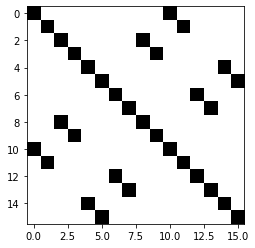

Von Neumann entropy: 	 (3.000000000000001+1.170056585980643e-15j)
Renyi alpha = 2: 	 (2.9999999999999982-0j)
Renyi alpha = 3: 	 (2.999999999999999+2.778529579867018e-34j)


In [132]:
l = 2
chain,vs=rti_chain(l,d=4,closed=True)
res = tn.contractors.greedy(chain+vs,output_edge_order=[vs[i//2][2+(i%2)] for i in range(2*l)])
copy = tn.Node(np.conjugate(res.get_tensor()))
for i in range(l):
    res[2*i] ^ copy[2*i]
rho = tn.contractors.greedy([res, copy],output_edge_order=[res[i] for i in range(1,2*l,2)]+[copy[i] for i in range(1,2*l,2)])
s = rho.get_tensor().reshape((4**l,4**l))

# visualization
plt.clf()
plt.imshow(np.abs(s),interpolation='nearest',cmap='Greys')
plt.show()

# compute entropy
print("Von Neumann entropy: \t", - np.trace(s @ linalg.logm(s)/np.log(2)))

# compute renyis
print("Renyi alpha = 2: \t", renyi_n(s, 2, 2))
print("Renyi alpha = 3: \t", renyi_n(s, 3, 2))